In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam # - Works
import random
from glob import glob
import seaborn as sns
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import matplotlib.image as img
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -rf '/content/data/'

In [ ]:
data_dir_train = pathlib.Path("/content/drive/MyDrive/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/Test")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


PREPARING DATASET

In [ ]:
batch_size = 32
img_height = 180
img_width = 180
rnd_seed = 123
random.seed(rnd_seed)

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.9,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 106 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
class_names_train = test_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


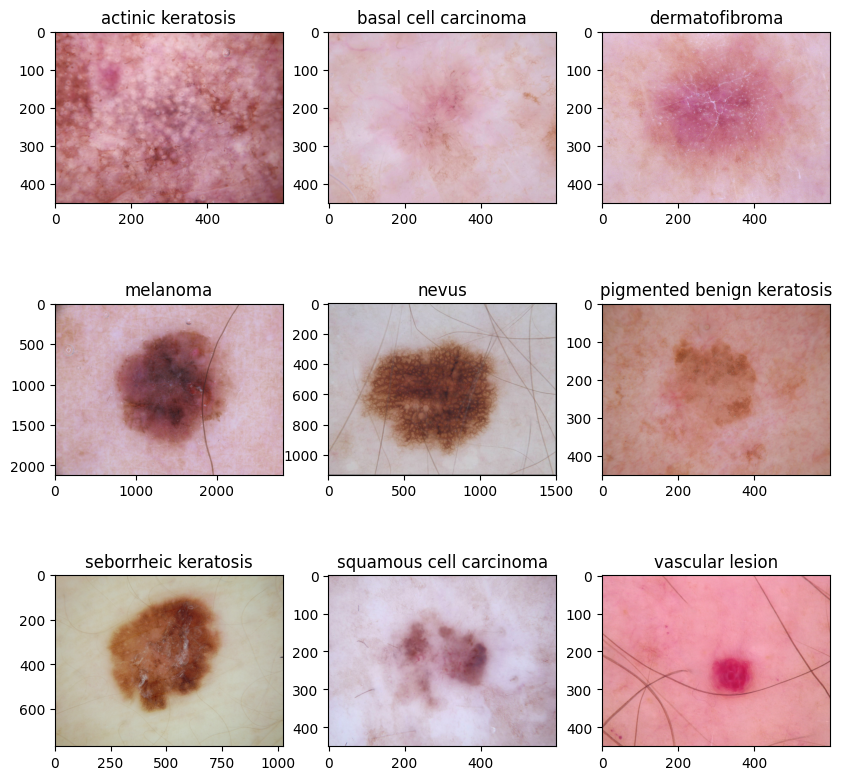

In [ ]:
num_classes = len(class_names)
plt.figure(figsize=(10,10))
for i in range(num_classes):
  plt.subplot(3,3,i+1)
  image = img.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

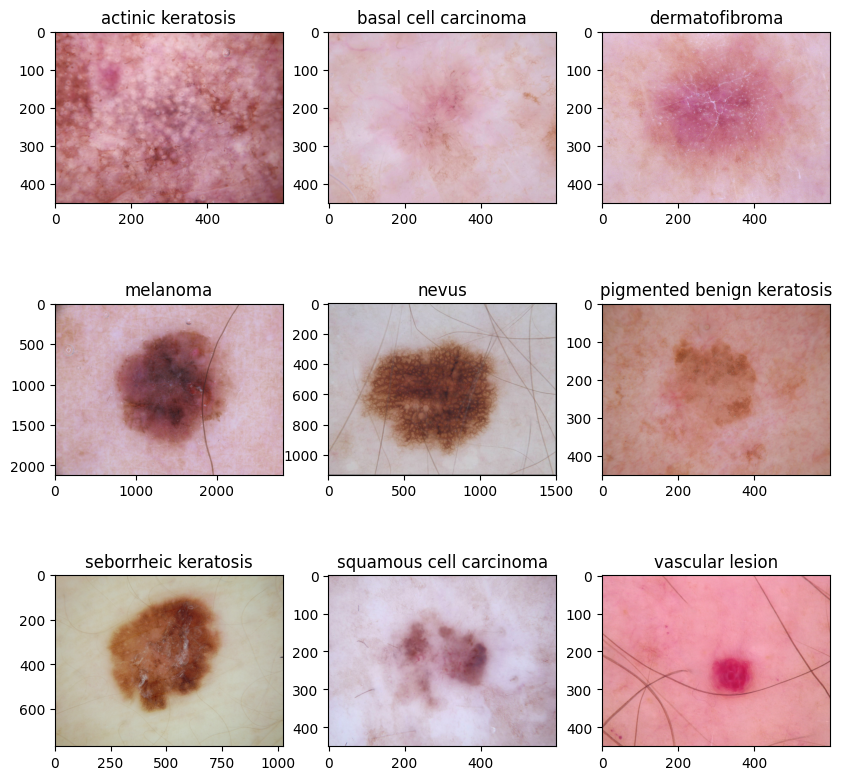

In [ ]:
num_classes = len(class_names_train)
plt.figure(figsize=(10,10))
for i in range(num_classes):
  plt.subplot(3,3,i+1)
  image = img.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)


In [ ]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Analysing Class Imbalance In Data

total training image count = 2239 

-------------------------------------
Class name =  actinic keratosis
count      =  114
proportion =  0.05091558731576597
-------------------------------------
Class name =  basal cell carcinoma
count      =  376
proportion =  0.16793211255024565
-------------------------------------
Class name =  dermatofibroma
count      =  95
proportion =  0.04242965609647164
-------------------------------------
Class name =  melanoma
count      =  438
proportion =  0.19562304600267977
-------------------------------------
Class name =  nevus
count      =  357
proportion =  0.15944618133095131
-------------------------------------
Class name =  pigmented benign keratosis
count      =  462
proportion =  0.20634211701652524
-------------------------------------
Class name =  seborrheic keratosis
count      =  77
proportion =  0.03439035283608754
-------------------------------------
Class name =  squamous cell carcinoma
count      =  181
proportion =  0.08083966056

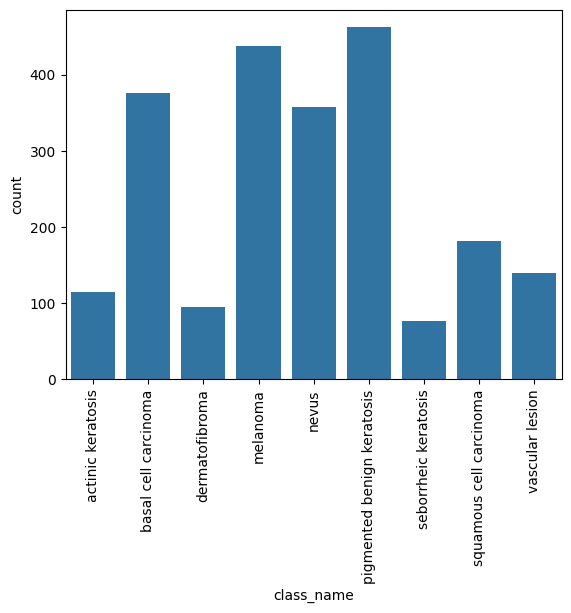

In [ ]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])

temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

AUGMENTOR

In [ ]:
!pip install Augmentor

In [ ]:
path_to_training_dataset = '/content/drive/MyDrive/Train'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(os.path.join(path_to_training_dataset, i), output_directory='/content/data/'+i+'/output/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000)

Initialised with 114 image(s) found.
Output directory set to /content/data/actinic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78C5B8CCFBE0>: 100%|██████████| 1000/1000 [00:47<00:00, 20.96 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/data/basal cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78C5B8AD9F90>: 100%|██████████| 1000/1000 [00:40<00:00, 24.56 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/data/dermatofibroma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78C5B8AA9F60>: 100%|██████████| 1000/1000 [00:40<00:00, 24.42 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/data/melanoma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x78C5C0077040>: 100%|██████████| 1000/1000 [03:10<00:00,  5.24 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/data/nevus/output/.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x78C5C0045DE0>: 100%|██████████| 1000/1000 [02:54<00:00,  5.74 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/data/pigmented benign keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78C5BADDA320>: 100%|██████████| 1000/1000 [00:36<00:00, 27.06 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/data/seborrheic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78C5C0077370>: 100%|██████████| 1000/1000 [01:29<00:00, 11.23 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/data/squamous cell carcinoma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78C5BAD45930>: 100%|██████████| 1000/1000 [00:39<00:00, 25.23 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/data/vascular lesion/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78C5BAE49840>: 100%|██████████| 1000/1000 [00:41<00:00, 24.29 Samples/s]


In [ ]:
output_dir = pathlib.Path('/content/data/')
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

9000


total training image count = 9000 

-------------------------------------
Class name =  actinic keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  basal cell carcinoma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  dermatofibroma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  melanoma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  nevus
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  pigmented benign keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  seborrheic keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  squamous cell carcinoma
count      =  1000
proportion =  0.11111111

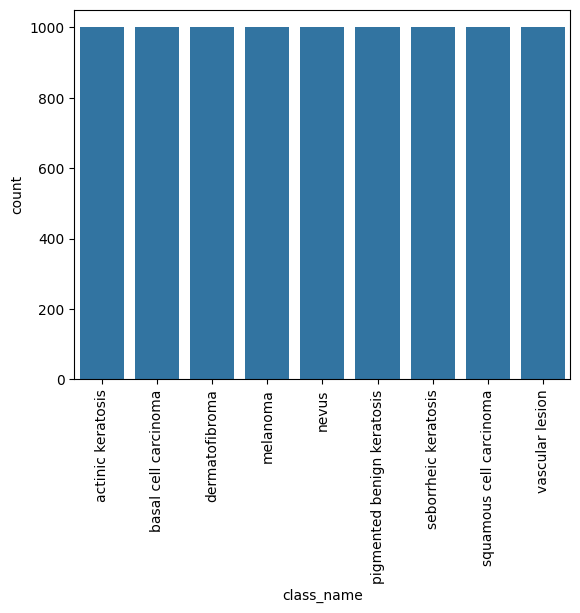

In [ ]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []

for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])


temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 7200 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 1800 files for validation.


In [ ]:
print(train_ds.class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(img_height,img_width,3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))

In [ ]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer= opt,
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
225/225 [==============================] - 987s 4s/step - loss: 1.9788 - accuracy: 0.2165 - val_loss: 1.6034 - val_accuracy: 0.3589
Epoch 2/15
225/225 [==============================] - 949s 4s/step - loss: 1.5394 - accuracy: 0.3856 - val_loss: 1.4598 - val_accuracy: 0.3894
Epoch 3/15
225/225 [==============================] - 948s 4s/step - loss: 1.4174 - accuracy: 0.4357 - val_loss: 1.3710 - val_accuracy: 0.4450
Epoch 4/15
225/225 [==============================] - 939s 4s/step - loss: 1.3188 - accuracy: 0.4835 - val_loss: 1.2810 - val_accuracy: 0.5061
Epoch 5/15
225/225 [==============================] - 947s 4s/step - loss: 1.2063 - accuracy: 0.5272 - val_loss: 1.2368 - val_accuracy: 0.5111
Epoch 6/15
225/225 [==============================] - 955s 4s/step - loss: 1.1316 - accuracy: 0.5572 - val_loss: 1.1751 - val_accuracy: 0.5472
Epoch 7/15
225/225 [==============================] - 918s 4s/step - loss: 1.0211 - accuracy: 0.6085 - val_loss: 0.9374 - val_accuracy: 0.6539

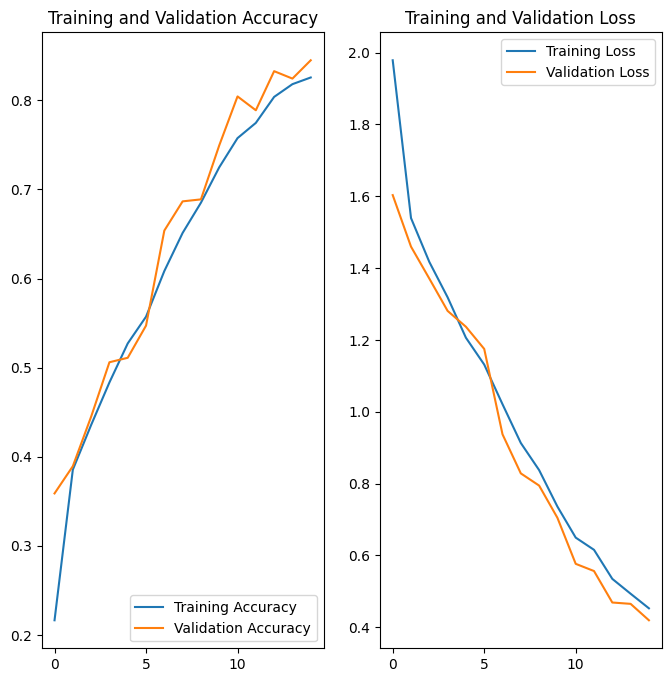

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 302ms/step


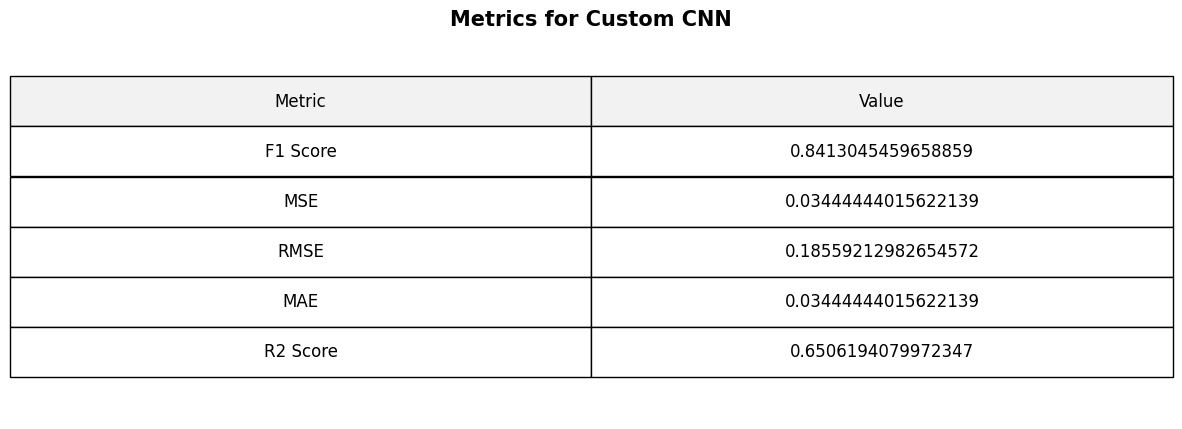

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score

def compute_metrics(model, data_loader):
    y_true = []
    y_pred = []

    for x, y in data_loader:
        # Store true labels
        y_true.extend(y.numpy())
        # Get model predictions
        preds = model.predict(x)
        # Convert predictions to class labels
        preds_class = np.argmax(preds, axis=1)
        y_pred.extend(preds_class)

    # Calculate F1 score
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Treat class labels as continuous for regression metrics (not typical for classification)
    y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)
    y_pred_one_hot = tf.keras.utils.to_categorical(y_pred, num_classes=num_classes)

    mse = mean_squared_error(y_true_one_hot, y_pred_one_hot)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_one_hot, y_pred_one_hot)
    r2 = r2_score(y_true_one_hot, y_pred_one_hot)

    return f1, mse, rmse, mae, r2



f1_model, mse_model, rmse_model, mae_model, r2_model = compute_metrics(model, val_ds)

# Function to print metrics in a box
def plot_metrics_box(model_name, f1, mse, rmse, mae, r2):
    # Create a DataFrame with the metrics data
    metrics_data = {
        'Metric': ['F1 Score', 'MSE', 'RMSE', 'MAE', 'R2 Score'],
        'Value': [f1, mse, rmse, mae, r2]
    }
    df = pd.DataFrame(metrics_data)

    # Plotting the table
    fig, ax = plt.subplots(figsize=(10, 5))  # Increased figure size for better view
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center', colColours=["#f2f2f2"]*2)

    table.auto_set_font_size(False)
    table.set_fontsize(12)  # Increase font size
    table.scale(1.5, 3)  # Increase cell size

    plt.title(f"Metrics for {model_name}", fontsize=15, weight='bold')
    plt.show()

# Print metrics for model
plot_metrics_box("Custom CNN", f1_model, mse_model, rmse_model, mae_model, r2_model)

In [ ]:
model.save("skin_cancer_classification_model.h5")